# Colab setup


In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
0.4.0
True


In [0]:
!pip3 install Pillow==4.0.0
!pip3 install PIL
!pip3 install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

import numpy as np
import pandas as pd
import os
from PIL import Image

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.6MB/s 


In [0]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Dataset

In [0]:
downloaded = drive.CreateFile({'id': '1dvhJaM3kO5lzWlQprKIKgV6GRS4LqT5c'})
downloaded.GetContentFile('train.zip')
downloaded = drive.CreateFile({'id': '1rh6bJymqTsqMwBCRSBy67kteWQC3TKLr'})
downloaded.GetContentFile('test.csv')
downloaded = drive.CreateFile({'id': '16OwlhaHXsEB4d4dTmDJl_FDEabO9E6GQ'})
downloaded.GetContentFile('training.csv')

In [0]:
#!rm -rf train_images

In [0]:
%%capture
!unzip train.zip

In [0]:
train = pd.read_csv('training.csv')
#train.head()

In [0]:
#Shuffling dataset
from sklearn.utils import shuffle
train = shuffle(train)
train = train.reset_index(drop=True)

In [0]:
#train[:32*120]

In [0]:
train.head()

,image_name,x1,x2,y1,y2
0,train11575,104,560,126,312
1,train7126,0,640,0,480
2,train10399,212,427,83,457
3,train13723,122,487,32,460
4,train4011,82,617,66,435


In [0]:
#Putting labels in a torch tensor and reshaping to (size x 4) + normalizing
train_labels = torch.tensor(([(train['x1']/640).tolist(),(train['x2']/640).tolist(),(train['y1']/480).tolist(),(train['y2']/480).tolist()]))
train_labels = torch.transpose(train_labels,0,1)
#train_labels = train_labels-0.5
train_names = train['image_name']

In [0]:
print('Sample lables')
print(train_labels[:10])

Sample lables
tensor([[ 0.1625,  0.8750,  0.2625,  0.6500],
        [ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.3313,  0.6672,  0.1729,  0.9521],
        [ 0.1906,  0.7609,  0.0667,  0.9583],
        [ 0.1281,  0.9641,  0.1375,  0.9062],
        [ 0.0766,  0.9578,  0.1729,  0.8687],
        [ 0.0938,  0.8781,  0.2604,  0.7500],
        [ 0.0000,  0.7937,  0.0312,  0.9104],
        [ 0.0922,  0.8953,  0.3208,  0.7042],
        [ 0.3031,  0.6594,  0.2667,  0.7958]])


In [0]:
tfms = transforms.Compose([transforms.Resize((224,224)),transforms.transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
def getImage(name):
  """
  Returns image specified by the name as torch.tensor"""
  img_name = os.path.join("/content/train_images/", name)
  image = Image.open(img_name)
  if tfms:
    image = tfms(image)
  return image

In [0]:
print('Size of input image:',getImage('train0').shape)
# I checked, all images are of the same size (480, 640) originally

Size of input image: torch.Size([3, 224, 224])


# Model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.count = 0
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32,3)
        #pool
        self.conv2 = nn.Conv2d(32, 32, 3)
        #pool
        self.conv3 = nn.Conv2d(32,32,3)
        #pool
        self.conv4 = nn.Conv2d(32,32,3)        
        #pool
        self.conv5 = nn.Conv2d(32,64,3)
        #pool
        self.conv6 = nn.Conv2d(64,64,3)
        self.conv7 = nn.Conv2d(64,64,3)
        #pool
        self.bnorm128 = nn.BatchNorm2d(64)
        self.bnorm32 = nn.BatchNorm2d(32)
        self.b1d = nn.BatchNorm1d(4)
        self.fc1 = nn.Linear(1792, 4)  #4*7*64

    def forward(self, x):
        self.count += 1
        x = (F.relu(self.conv1(x)))
        x = self.pool(x)
        x = (F.relu(self.conv2(x)))
        x = self.pool(x)
        #x = F.dropout(x,p=0.3)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        #x = self.bnorm32(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        #x = F.dropout(x,p=0.3)
        x = (F.relu(self.conv5(x)))
        x = self.pool(x)
        x = (F.relu(self.conv6(x)))
        #x = self.bnorm128(x)
        x = (F.relu(self.conv7(x)))
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1, 1792) #Batch_size x 1792
        x = self.fc1(x) #Batch_size x 4
        #x = self.b1d(x)
        if(self.count%32==0):
          print(x)
        #x = F.sigmoid(x)
        return x

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        #print(input.shape)
        p = input.view(input.size(0), -1)
        return (p)

In [0]:
#Hyperparameters
NUM_EPOCHS = 10
LR = (5*1e-3)
BATCH_SIZE = 32
GAMMA = 0.6 #LR Decay
curr_lr = LR
WD = 1e-5
MOMENTUM = 0.9

In [0]:
model = models.resnet34(pretrained=True)

model = nn.Sequential(*list(model.children())[:-2],
                    # nn.Dropout(),
                     nn.Conv2d(512, 32, 3),
                     nn.ReLU(),Flatten(),
                     nn.Linear(800,4))

#model = Net()
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'Sample file.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
#print(model.children)
#Freezing early layers
count = 0
for param in model.parameters():
    param.requires_grad = False
    count += 1
    if count >=7 :
        break

In [0]:
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training

In [0]:
losses = []
accuracies = []
validation_accuracies=[]

In [0]:
def validation_accuracy(model):
  """
  Performs inference on the Validation set and returns the reported accuracy
  """
  correct = 0
  
  with torch.no_grad():
    for idx in range(0,99):
      data = getitem(test_indexes[idx])
      image = data['image']
      exp = data['category']
      image = image.unsqueeze(0).cuda()
      target = model(image)
      ans = (torch.argmax(target).cpu().numpy()+1)
      if (ans == exp):
        correct +=1
  return (correct/99)

  

In [0]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    #accuracy = 0
    #count = 0
    curr_lr *= GAMMA
    adjust_learning_rate(optimizer, curr_lr)
  
    
    optimizer.zero_grad()
    for c in range(0,int(len(train)/BATCH_SIZE)):
        optimizer.zero_grad()
        
        #if (c==100):
        #  torch.save(model.state_dict(), "model_at_100epoch_"+str(epoch)+"pt")
          #curr_lr *= GAMMA
          #adjust_learning_rate(optimizer, curr_lr)
        
        images = torch.zeros([BATCH_SIZE,3,224,224])
        for p in range(0,BATCH_SIZE):
            images[p,:,:,:] = getImage(train_names[c*BATCH_SIZE+p])
        
        targets = train_labels[c*BATCH_SIZE:(c+1)*BATCH_SIZE]
        targets = targets.float()
        
        if torch.cuda.is_available():
            images = images.cuda()
            targets = targets.cuda()
        
        outs = model(images)
        #print(outs.shape)
        loss = criterion(outs, targets)
        loss.backward()
        optimizer.step()
                
        total_loss += loss.data
        #accuracy += torch.sum(torch.argmax(outs, dim=1) == targets)
        #count += 1

        if c%10 == 0:
            print("Epoch:", epoch, "Iter:", c, "average batch loss:", total_loss/(c+1))
    
    
    #print("\nEpoch:", epoch, "Total loss:", total_loss)
    #acc = accuracy.cpu().numpy()/(count*BATCH_SIZE)
    #print("Epoch:", epoch, "Accuracy:", acc,'\n') 
    
    #model.eval()
    #val_acc = validation_accuracy(model)
    #print('Validation accuracy:',val_acc)
    #model.train()
    
    torch.save(model.state_dict(), "model_at_epoch_"+str(epoch)+"pt")
    losses.append(total_loss)
    #accuracies.append(acc)
    #validation_accuracies.append(val_acc)
    #validation_losses.append(val_loss)

Epoch: 0 Iter: 0 average batch loss: tensor(0.6173, device='cuda:0')
Epoch: 0 Iter: 10 average batch loss: tensor(0.1692, device='cuda:0')
Epoch: 0 Iter: 20 average batch loss: tensor(0.1109, device='cuda:0')
Epoch: 0 Iter: 30 average batch loss: tensor(1.00000e-02 *
       8.3529, device='cuda:0')
Epoch: 0 Iter: 40 average batch loss: tensor(1.00000e-02 *
       6.7296, device='cuda:0')
Epoch: 0 Iter: 50 average batch loss: tensor(1.00000e-02 *
       5.6916, device='cuda:0')
Epoch: 0 Iter: 60 average batch loss: tensor(1.00000e-02 *
       4.9669, device='cuda:0')
Epoch: 0 Iter: 70 average batch loss: tensor(1.00000e-02 *
       4.4251, device='cuda:0')
Epoch: 0 Iter: 80 average batch loss: tensor(1.00000e-02 *
       4.0250, device='cuda:0')
Epoch: 0 Iter: 90 average batch loss: tensor(1.00000e-02 *
       3.7024, device='cuda:0')
Epoch: 0 Iter: 100 average batch loss: tensor(1.00000e-02 *
       3.4334, device='cuda:0')
Epoch: 0 Iter: 110 average batch loss: tensor(1.00000e-02 *
  

KeyboardInterrupt: ignored

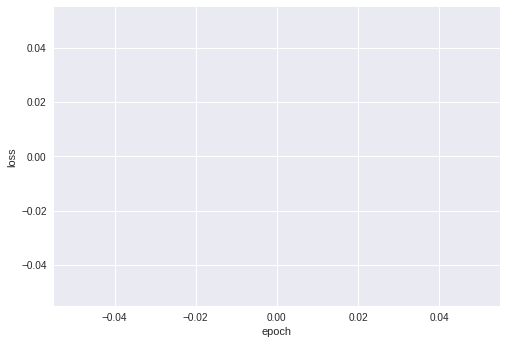

In [0]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
import matplotlib.pyplot as plt
plt.plot(accuracies,'C0',label='Trainset accuracies')
plt.plot(validation_accuracies,'C1',label='Validation accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Save/load model

In [0]:
torch.save(model.state_dict(), "model.pt")

In [0]:
model.load_state_dict(torch.load("model_at_epoch_0pt"))
model.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bnorm128): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1792, out_features=4, bias=True)
)

# Exporting solution to csv

In [0]:
downloaded = drive.CreateFile({'id': '1GBix_QORVrfRmbg9mLmwWnBQgMxHQV2Z'})
downloaded.GetContentFile('test_images.zip')

In [0]:
%%capture
!unzip test_images.zip

In [0]:
from tqdm import tqdm

In [0]:
#len(test)

In [0]:
def answer_builder(model):
  """
  Performs inference on testset and exports predictions to answer.csv
  """
  model.eval()
  test = pd.read_csv('test.csv')
  test_names = test['image_name']
  images =torch.empty([55,3,224,224])
  with torch.no_grad():
    for itr in tqdm(range(0,int(len(test_names)/55))):
      for idx in (range(55*itr,55*(itr+1))):
        img_name = os.path.join("/content/test_images/", test_names[idx])
        image = Image.open(img_name)
        image = tfms(image)
        image = image.unsqueeze(0)
        images[idx-55*itr,:,:,:] = image
   # print('\nPerforming inference...')
      images = images.cuda()
      target = model(images) #55x4
      target = torch.stack((target[:,0]*640,target[:,1]*640,target[:,2]*480,target[:,3]*480),1)
      target = torch.round(target)
   # print('Generating answer.csv')
      for i in range(0,55):
        test.loc[55*itr+i] = [test_names[55*itr+i]] +  target[i].tolist()

    test.to_csv('answer.csv', index=False)

In [0]:
answer_builder(model)


100%|██████████| 233/233 [04:53<00:00,  1.24s/it]


In [0]:
ans = pd.read_csv('answer.csv')

In [0]:
ans

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,246.0,481.0,59.0,425.0
1,1473231475010DeeplearnS11276.png,112.0,536.0,142.0,374.0
2,JPEG_20161205_135307_1000155917326.png,174.0,528.0,40.0,471.0
3,JPEG_20160711_123440_1000518778437.png,243.0,410.0,84.0,390.0
4,JPEG_20160803_115329_100034020722.png,85.0,489.0,68.0,414.0
5,147444974116511473239803010-Mast--Harbour-Men-...,86.0,445.0,85.0,404.0
6,JPEG_20160622_110649_1000527459853.png,98.0,454.0,111.0,366.0
7,JPEG_20160823_120737_1000784898268.png,70.0,469.0,80.0,399.0
8,1480965956645IMG_3094.png,174.0,550.0,100.0,409.0
9,14732348976417a565e40d545452688130062b267a2d2.png,71.0,580.0,55.0,416.0


In [0]:
ans = pd.read_csv('answer.csv')
for i in tqdm(range(len(ans))):
  if(ans['x1'][i]<0):
    ans['x1'][i]=0
  elif(ans['x1'][i]>640):
    ans['x1'][i]=640
    
  if(ans['x2'][i]<0):
    ans['x2'][i]=0
  elif(ans['x2'][i]>640):
    ans['x2'][i]=640
    
  if(ans['y1'][i]<0):
    ans['y1'][i]=0
  elif(ans['y1'][i]>480):
    ans['y1'][i]=480
    
  if(ans['y2'][i]<0):
    ans['y2'][i]=0
  elif(ans['y2'][i]>480):
    ans['y2'][i]=480


  0%|          | 0/12815 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

  0%|          | 6/12815 [00:00<04:40, 45.72it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removi

In [0]:
ans.to_csv('answer.csv', index=False)